In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
pd.options.display.max_rows = 100
pd.options.mode.copy_on_write = True

In [2]:
df = pd.read_csv('fr.openfoodfacts.org.products.csv',sep = '\t',low_memory=False)
df.describe()


,no_nutriments,additives_n,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,nutrition_grade_uk,energy_100g,energy-from-fat_100g,fat_100g,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
count,0.0,248939.000000,248939.000000,0.0,248939.000000,0.0,0.0,2.611130e+05,857.000000,243891.000000,...,49.000000,3036.000000,165.000000,948.000000,0.0,268.000000,221210.000000,221210.000000,0.0,0.0
mean,NaN,1.936024,0.019659,NaN,0.055246,NaN,NaN,1.141915e+03,585.501214,12.730379,...,6.425698,31.458587,15.412121,49.547785,NaN,341.700764,9.165535,9.058049,NaN,NaN
std,NaN,2.502019,0.140524,NaN,0.269207,NaN,NaN,6.447154e+03,712.809943,17.578747,...,2.047841,31.967918,3.753028,18.757932,NaN,425.211439,9.055903,9.183589,NaN,NaN
min,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,8.000000,6.000000,NaN,0.000000,-15.000000,-15.000000,NaN,NaN
25%,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,3.770000e+02,49.400000,0.000000,...,6.300000,0.000000,12.000000,32.000000,NaN,98.750000,1.000000,1.000000,NaN,NaN
50%,NaN,1.000000,0.000000,NaN,0.000000,NaN,NaN,1.100000e+03,300.000000,5.000000,...,7.200000,23.000000,15.000000,50.000000,NaN,195.750000,10.000000,9.000000,NaN,NaN
75%,NaN,3.000000,0.000000,NaN,0.000000,NaN,NaN,1.674000e+03,898.000000,20.000000,...,7.400000,51.000000,15.000000,64.250000,NaN,383.200000,16.000000,16.000000,NaN,NaN
max,NaN,31.000000,2.000000,NaN,6.000000,NaN,NaN,3.251373e+06,3830.000000,714.290000,...,8.400000,100.000000,25.000000,100.000000,NaN,2842.000000,40.000000,40.000000,NaN,NaN


<Axes: >

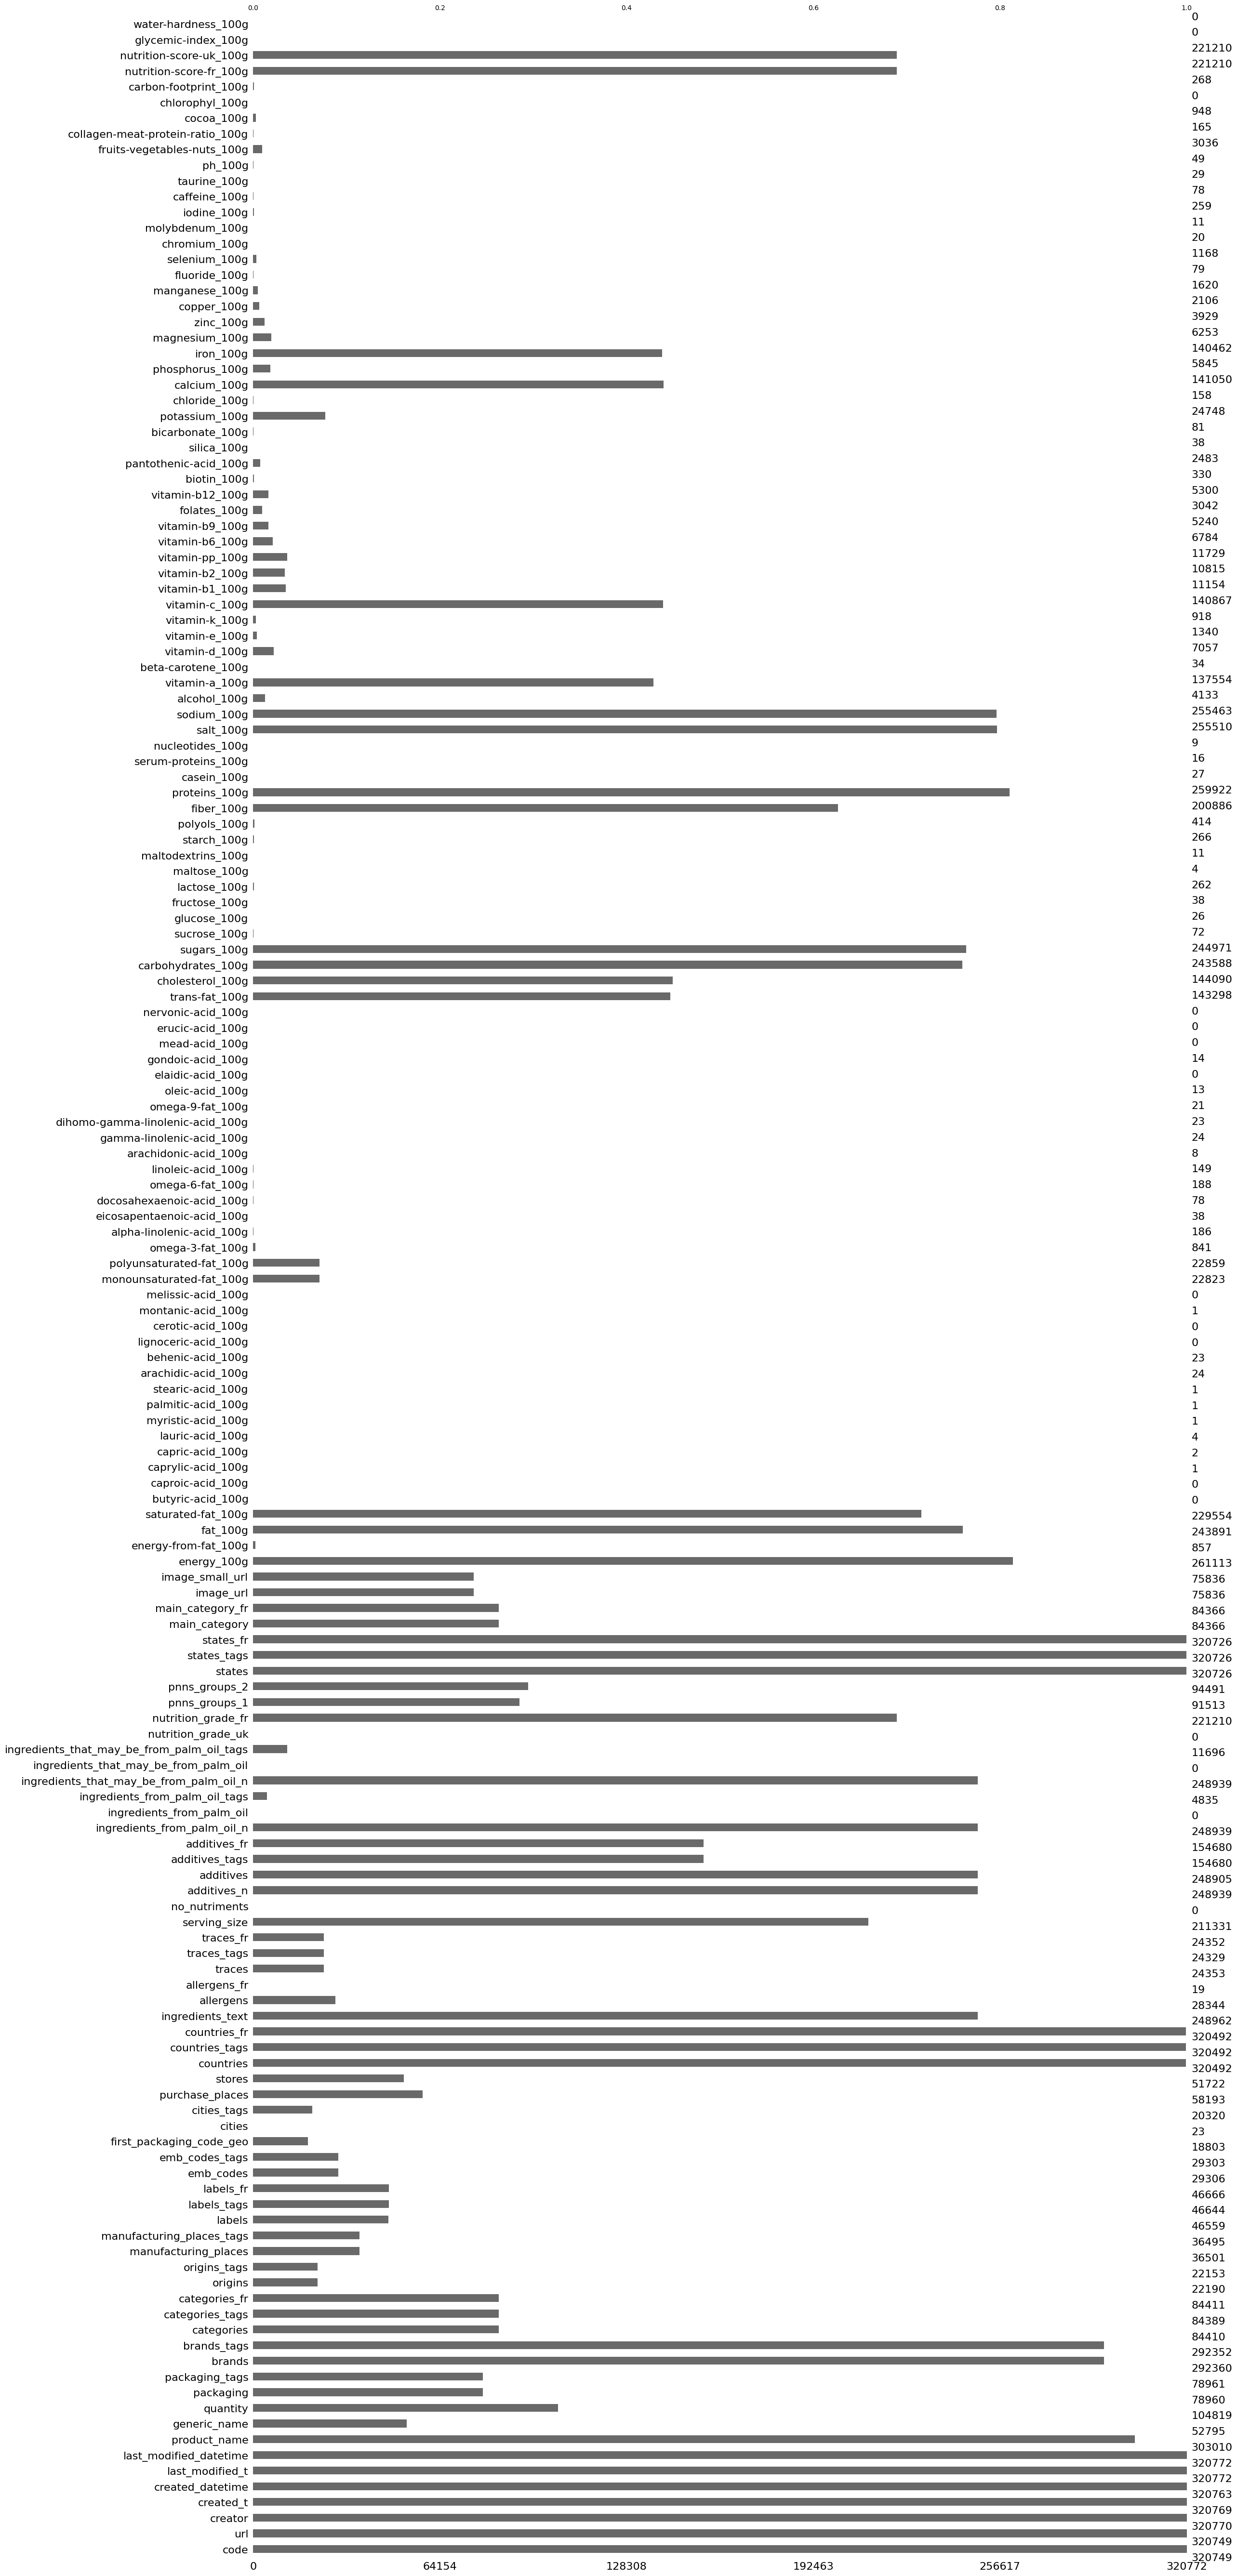

In [3]:
%matplotlib inline
msno.bar(df)

In [4]:

df.columns

Index(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name',
       'generic_name', 'quantity',
       ...
       'ph_100g', 'fruits-vegetables-nuts_100g',
       'collagen-meat-protein-ratio_100g', 'cocoa_100g', 'chlorophyl_100g',
       'carbon-footprint_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g', 'glycemic-index_100g',
       'water-hardness_100g'],
      dtype='object', length=162)

In [5]:
df.drop(columns=['url', 'creator', 'created_t', 'created_datetime','last_modified_t', 'last_modified_datetime','countries','countries_tags','countries_fr','image_url','image_small_url','states','states_tags','states_fr'],inplace=True)
cols_to_drop = df.filter(regex='_n$').columns
df.drop(columns=cols_to_drop, inplace=True)
cols_to_drop = df.filter(regex='^state').columns

df.drop(columns=cols_to_drop, inplace=True)

<Axes: >

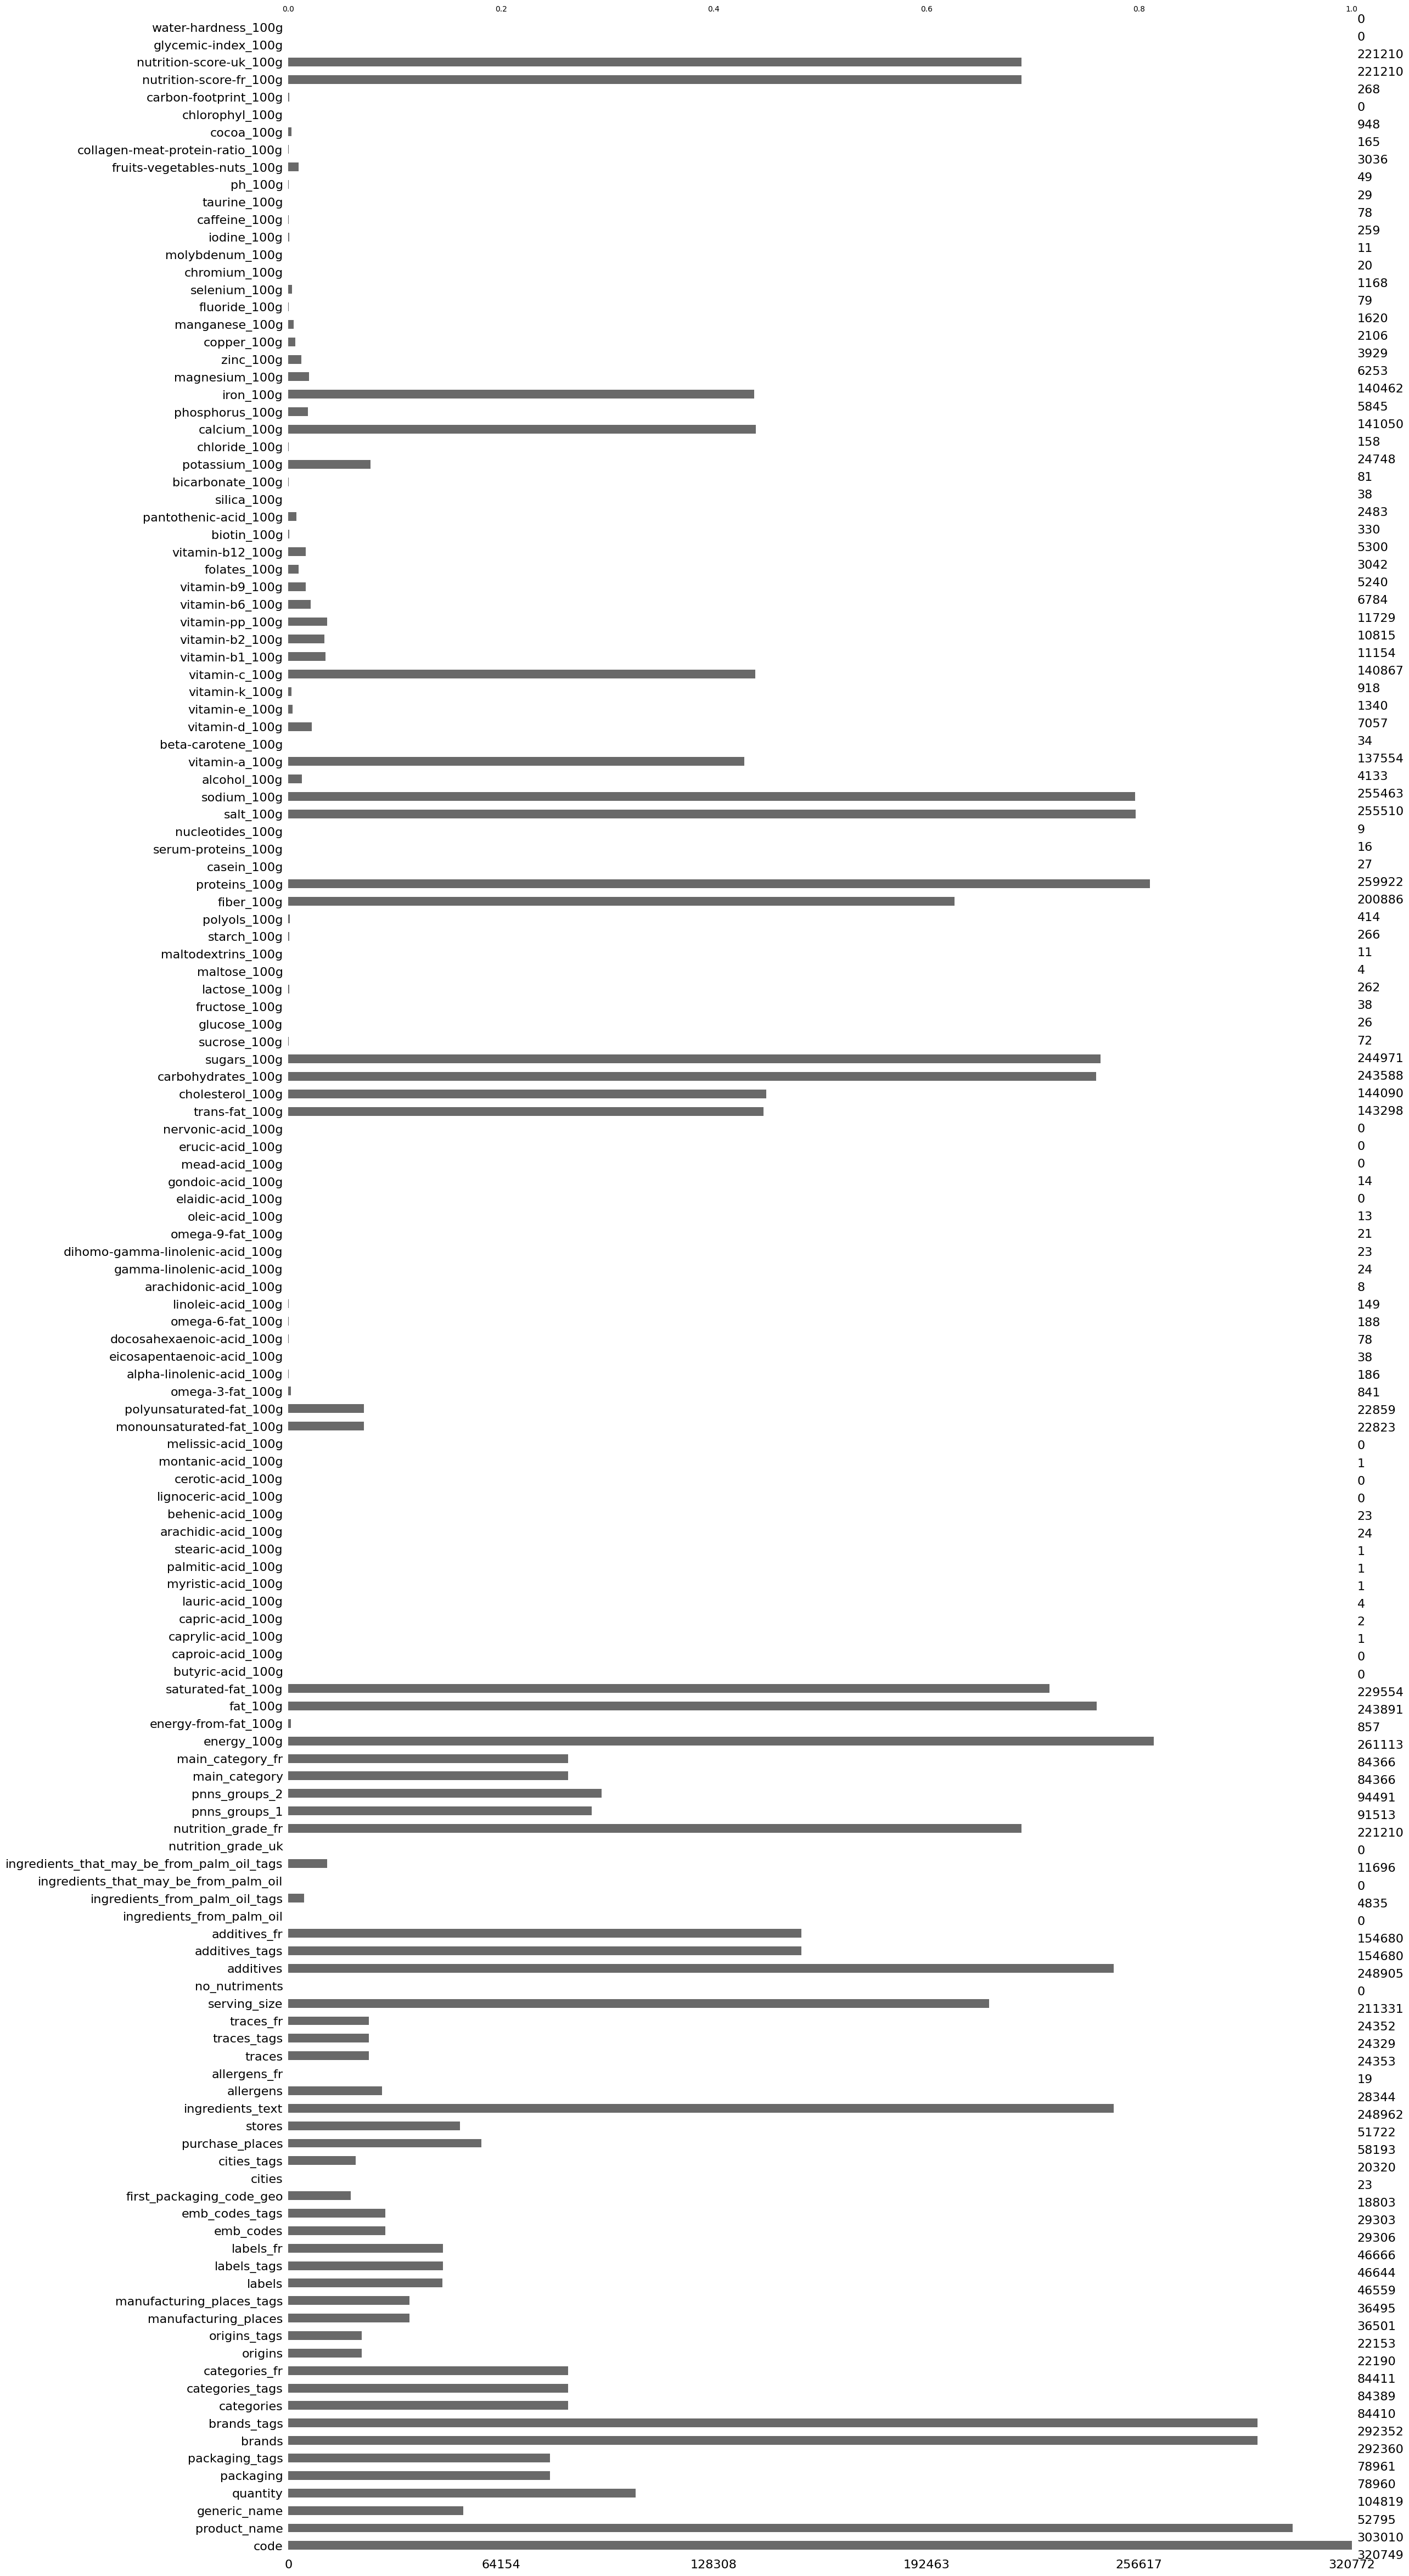

In [6]:
msno.bar(df)

In [7]:

# Calculer le nombre total de lignes
total_rows = len(df)

# Calculer le nombre de valeurs non nulles dans chaque colonne
non_null_counts = df.notna().sum()

# Calculer le taux de remplissage de chaque colonne
filling_rates = non_null_counts / total_rows * 100

# Filtrer les colonnes avec un taux de remplissage entre 20% et 50%
selected_columns = filling_rates[(filling_rates >= 5) ].index

# Conserver uniquement les colonnes sélectionnées
df_cleaned = df[selected_columns]
len(df_cleaned)

320772

<Axes: >

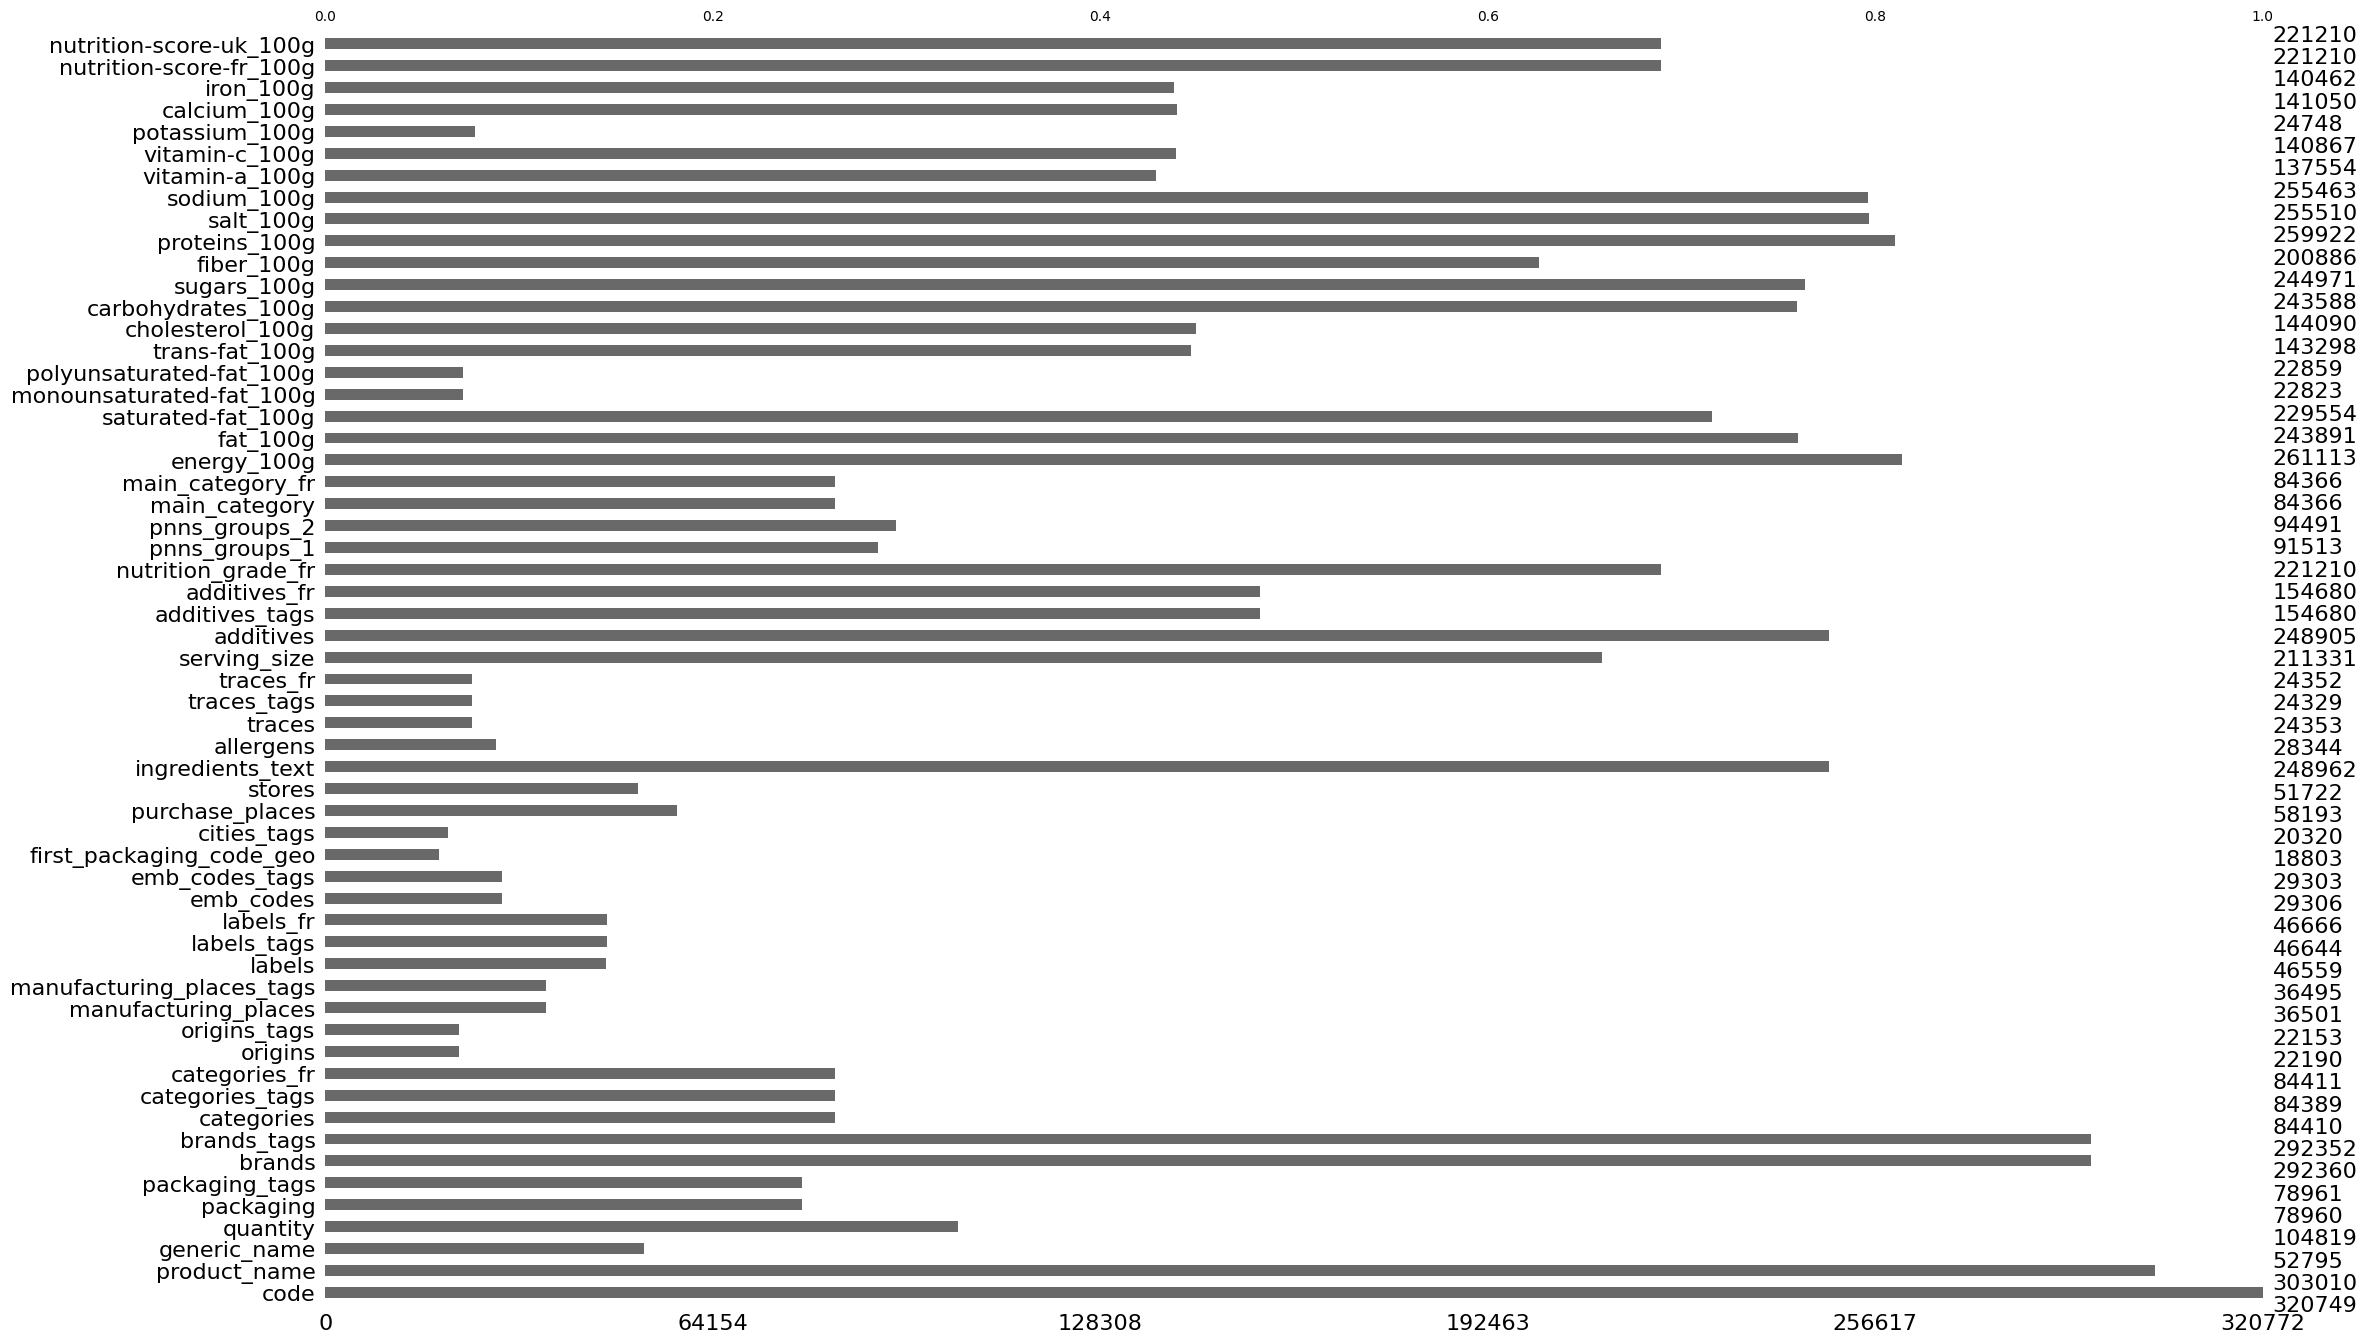

In [8]:
msno.bar(df_cleaned)

In [9]:
df_cleaned.drop_duplicates(subset=['code'])
len(df_cleaned)

320772

In [10]:
df_cible=df_cleaned.dropna(subset=['pnns_groups_1'])
df_cible_cleaned = df_cible[df_cible['pnns_groups_1']!= 'unknown']
len(df_cible)

91513

In [11]:
df_pnns1 = df_cible_cleaned['pnns_groups_1']
df_pnns1

174       Fruits and vegetables
175               Sugary snacks
177        Cereals and potatoes
180               Sugary snacks
182        Cereals and potatoes
                  ...          
320759    Fruits and vegetables
320763                Beverages
320765           Fish Meat Eggs
320766             Salty snacks
320769             Salty snacks
Name: pnns_groups_1, Length: 68889, dtype: object

In [12]:
counts = df_pnns1.value_counts().reset_index()
counts.columns = ['pnns_groups_1', 'Counts']
print(df_pnns1.value_counts())
# Créer le graphique avec Plotly
fig = px.bar(counts, x='pnns_groups_1', y='Counts', title='Value Counts de la variable pnns_groups_1')

# Afficher le graphique
fig.show()


pnns_groups_1
Sugary snacks              12368
Beverages                   9033
Milk and dairy products     8825
Cereals and potatoes        8442
Fish Meat Eggs              8041
Composite foods             6747
Fruits and vegetables       5908
Fat and sauces              5216
Salty snacks                2809
fruits-and-vegetables        987
sugary-snacks                496
cereals-and-potatoes          16
salty-snacks                   1
Name: count, dtype: int64


<Axes: >

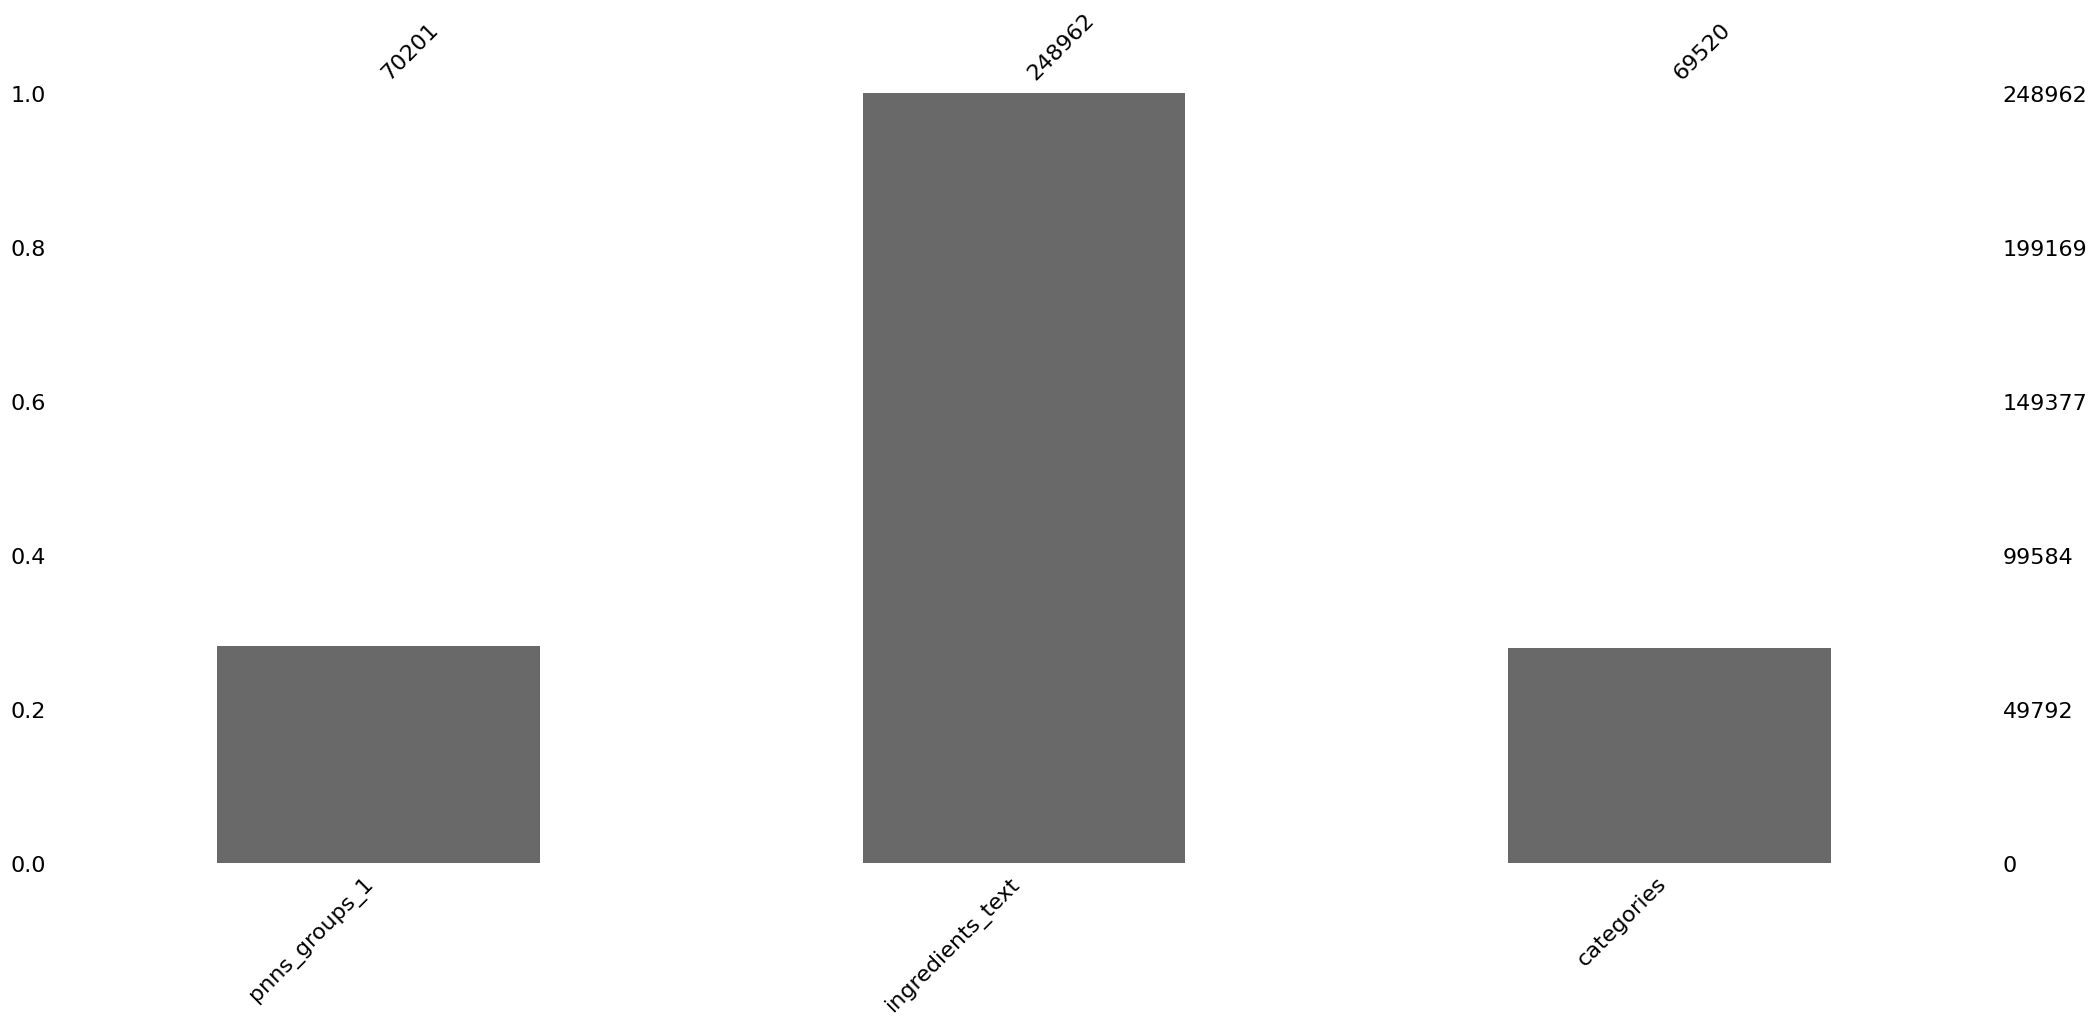

In [13]:
colonnes = ['pnns_groups_1','ingredients_text','categories']
df_select = df_cleaned.dropna(subset=['ingredients_text'])
df_travail = df_select[colonnes]

msno.bar(df_travail)


### remplacer les valeurs incohérentes

In [14]:
df_travail['pnns_groups_1']=df_travail.pnns_groups_1.replace({"-":" "},regex=True)
df_travail['pnns_groups_1']=df_travail['pnns_groups_1'].str.capitalize()
df_travail['pnns_groups_1'].value_counts()

pnns_groups_1
Unknown                    12366
Sugary snacks              10865
Milk and dairy products     7336
Cereals and potatoes        7152
Fish meat eggs              6980
Beverages                   6825
Fruits and vegetables       6032
Composite foods             6025
Fat and sauces              4226
Salty snacks                2394
Name: count, dtype: int64

### enlever les unknown

In [15]:
df_travail.drop(df_travail[df_travail['pnns_groups_1'] == 'Unknown'].index, inplace = True)
df_travail['pnns_groups_1'].value_counts()

pnns_groups_1
Sugary snacks              10865
Milk and dairy products     7336
Cereals and potatoes        7152
Fish meat eggs              6980
Beverages                   6825
Fruits and vegetables       6032
Composite foods             6025
Fat and sauces              4226
Salty snacks                2394
Name: count, dtype: int64

In [16]:
#df d'entrainement avec pnns group
df_train = df_travail.dropna(subset=['pnns_groups_1']) 
#DF sans pnns group
df_missing = df_travail[df['pnns_groups_1'].isna()]  


C:\Users\devil\AppData\Local\Temp\ipykernel_26956\1862913704.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [17]:
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(','), max_features=1000)

X_train = vectorizer.fit_transform(df_train['ingredients_text'])
X_missing = vectorizer.transform(df_missing['ingredients_text'])

# Encodage des labels
y_train = df_train['pnns_groups_1']
# Affichage de la matrice

c:\Users\devil\anaconda3\envs\PROJET3\Lib\site-packages\sklearn\feature_extraction\text.py:523: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



In [18]:
# Initialisation du classifieur KNN
knn = KNeighborsClassifier(n_neighbors=3)

# Entraînement du modèle
knn.fit(X_train, y_train)



KNeighborsClassifier(n_neighbors=3)

In [19]:
# Prédictions sur les données manquantes
y_pred_missing = knn.predict(X_missing)

# Remplir les valeurs manquantes dans le DataFrame original
df_travail.loc[df_travail['pnns_groups_1'].isna(), 'pnns_groups_1'] = y_pred_missing

print("\nDataFrame avec valeurs manquantes prédites:")
print(df)

<Axes: >

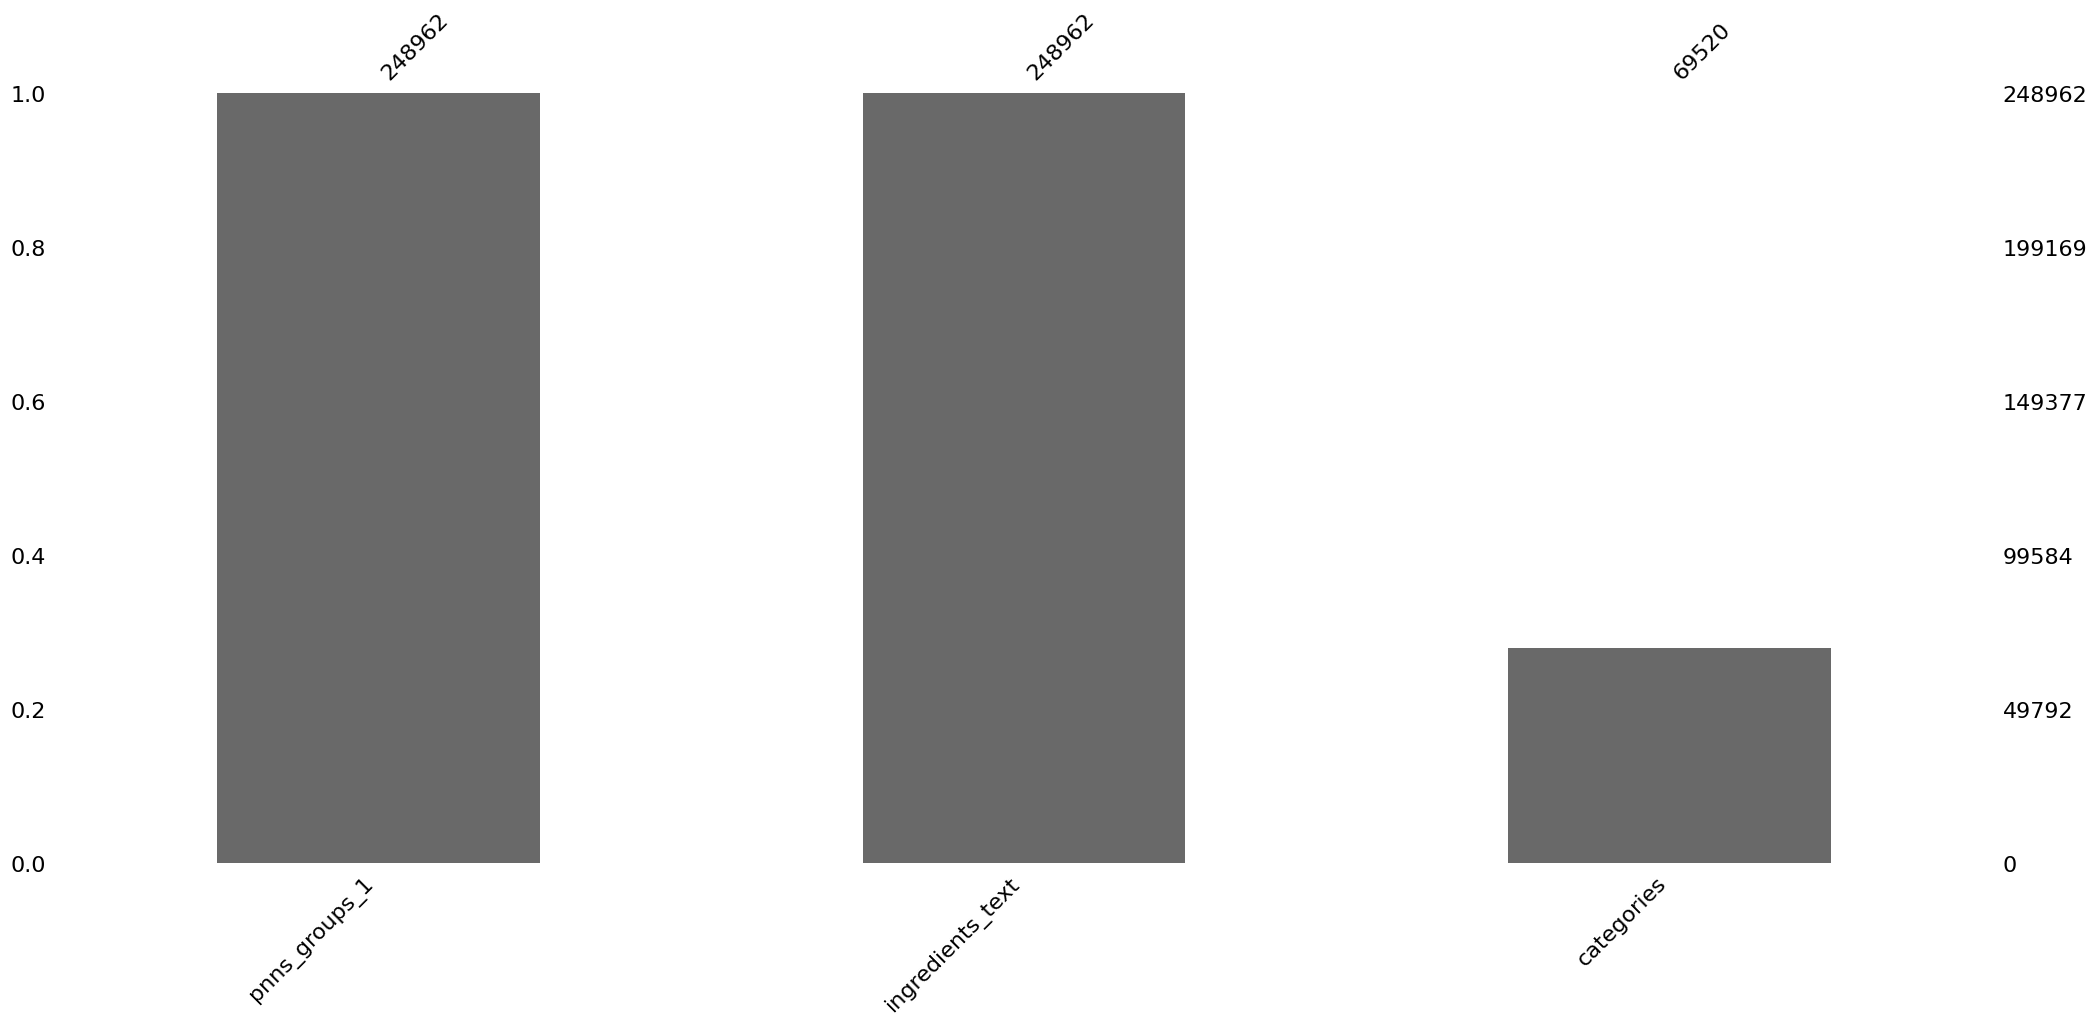

In [ ]:
msno.bar(df_travail)

In [ ]:
df_travail['pnns_groups_1'].value_counts()

pnns_groups_1
Cereals and potatoes       64480
unknown                    54122
Fat and sauces             28070
Beverages                  27509
Sugary snacks              24081
Milk and dairy products    12235
Fish Meat Eggs             11607
Fruits and vegetables       9066
Salty snacks                9013
Composite foods             7465
fruits-and-vegetables        882
sugary-snacks                415
cereals-and-potatoes          16
salty-snacks                   1
Name: count, dtype: int64